In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from sklearn.mixture import GaussianMixture
import sys
sys.path.append('../src/')
from forward_modeling import project_volume, slice_volume
from molecular_handling import particle
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import norm

In [3]:
def gmm_image_dataset(particles,size=100,noise=0.1,size_grid=32):
    """
    This function generates a dataset of images of the particules gives as argument
    (particles are rotated along on fixed axis)
    
        Arguments:
        ---------
        - particles (list): 
            list of the different particles in the dataset
        - size (int {default:100}): 
            lentgh of the dataset
        - noise (float {default: 0.1}):
            noise added to the images
        - size_grid (integer {default:32}):
            number of voxels along each grid direction
    """
    dataset = np.zeros((size, size_grid, size_grid))
    n_particles = len(particles)
    for t in range(size):
        iat = np.random.randint(n_particles)
        angle = np.random.rand() * 360
        rot = R.from_euler('z', angle, degrees = True)
        
        particles[iat].rotate(quat = rot.as_quat())
        dataset[t,:,:] = particles[iat].image
    
    return dataset + np.random.randn(dataset.shape[0], dataset.shape[1], dataset.shape[2])*noise

In [4]:
particle1 = particle(n_atom=3, rads_atom=[1.,2.,1.], size_grid = 32)
particle2 = particle(n_atom=2, rads_atom=[2.,2.], size_grid = 32)
particle3 = particle(n_atom=1, rads_atom=[3.], size_grid = 32)
particles = [particle1, particle2, particle3]

In [5]:
dataset = gmm_image_dataset(particles, noise=0.1)

# Simple gaussian mixture model applied directly to the images

Here, we simply train a gaussian mixture model on the dataset, and compare the images of the particles, and the means of the gaussians of the model.

In [6]:
reshaped_dataset = dataset.reshape(100,1024)
gm = GaussianMixture(3)
gm.fit(reshaped_dataset)

images = gm.means_.reshape(3,32,32)

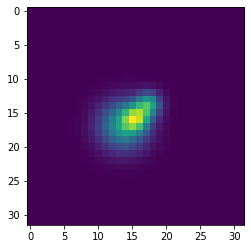

In [7]:
plt.imshow(particle1.image)

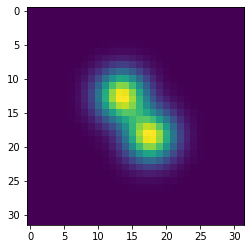

In [8]:
plt.imshow(particle2.image)

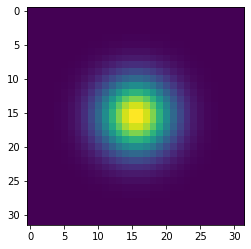

In [9]:
plt.imshow(particle3.image)

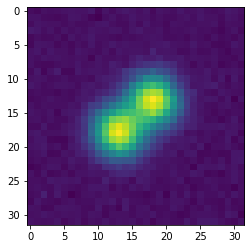

In [10]:
plt.imshow(images[0])

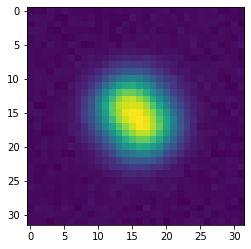

In [11]:
plt.imshow(images[1])

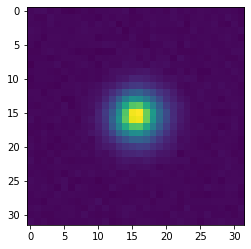

In [12]:
plt.imshow(images[2])

It worked quite good without having to find the orientations

# Marginalizing over the orientations

In this part, we built an algorithm that reconstruct the images of the particles, by marginalizing over the orientations.

In [14]:
def rot_mat(theta):
    """
    This function builds a rotation matrix of angle theta
    """
    #theta in radians
    c, s = np.cos(theta), np.sin(theta)
    mat = np.array(((c, -s), (s, c)))
    return mat
    

def rotate_image(image, theta):
    """
    This function rotates the image by an angle theta
    """
    rot = rot_mat(theta)
    N = image.shape[0]
    rot_image = np.zeros((N,N))
    x = np.linspace(-1,1,N)
    y = np.linspace(-1,1,N)
    interpolating_function = RegularGridInterpolator((x,y), image)

    for i in range(N):
        x = -1 + i*2/(N-1)
        for j in range(N):
            y = -1 + j*2/(N-1)
            vect = np.array((x,y))
            vect_ = rot @ vect
            if np.max(np.abs(vect_))<=1:
                rot_image[i,j] += interpolating_function(vect_)
                
    return rot_image

def proba(model, rotated_image):
    """
    This function calculates a probability score to tell how close two images are.
    """
    prob = 1
    for i in range(rotated_image.shape[0]):
        for j in range(rotated_image.shape[1]):
            prob*=(1 - norm.cdf(np.abs(model[i,j]-rotated_image[i,j]), loc = 0, scale = 1))*2
    return prob

def reconstruct(dataset, models, size):
    """
    This function reconstructs the models at step t+1 given the models at step t
    """
    thetas = np.linspace(0,360,size)
    dtheta = 2/size *np.pi
    next_models = np.zeros(models.shape)
    probs = np.zeros((len(dataset), len(thetas), models.shape[0]))
    for i in range(len(dataset)):
        print(i)
        for j in range(len(thetas)):
            for k in range(models.shape[0]):
                rotated_image = rotate_image(dataset[i], thetas[j])
                prob = proba(models[k], rotated_image) * dtheta
                probs[i,j,k]= prob
                next_models[k] += prob * rotated_image #we add the image, weighed by the probabity
                                                        #to construct the models at the next iteration
                
    for k in range(models.shape[0]):
        next_models[k]/np.sum(probs[:,:,k])
        
    return next_models

def EM(dataset, images_init):
    """
    This function iterates the reconstruct function to converge to a local optimum
    """
    return images_final

In [15]:
next_model = reconstruct(dataset, images, 10)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


KeyboardInterrupt: 

In [93]:
np.mean(next_model)

3.5343776318013434e-21

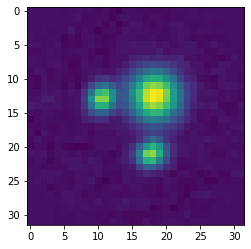

In [94]:
plt.imshow(next_model[0])

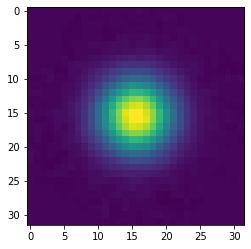

In [95]:
plt.imshow(next_model[1])

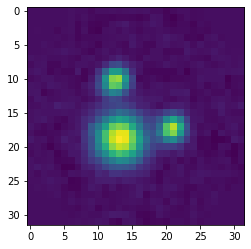

In [96]:
plt.imshow(next_model[2])